# lesson_2_DAN_CNN_Word2Vec_Embeddings_Classifier

**Description:** Text classification on the IMDB movie dataset using i) Deep Averaging Networks, and ii) Convolutions Neural Nets (CNN) and pre-trained Word2Vec word embeddings.<br>

Section 1 deals with setup and prerequisites, which does not need a lot of discussion.
Data acquisition and preparation are handled in section 2, and section 3 looks at DANs and CNNs.

## IMPORTANT NOTE:
Because of the environment built in to Colab, the software we're importing causes an error to be thrown the first time you run the cells in the Setup section.  As soon as you hit the error, you have to go to the Runtime menu and select 'Restart Session'.  Once the session is restarted you must rerun the cells in Setup and you will not run in to the error.

<a id = 'returnToTop'></a>

## Notebook Contents
  * 1. [Setup](#setup)
    * 1.1 [Static Word Embeddings](#wordembed)
  * 2. [Creation of the Dataset](#creationOfDataset)  
  * 3. [Modeling](#modeling)
    * 3.1 [Averaging Network (AN) Model](#averagingNetwork)
    * 3.2 [Deep Averaging Network (DAN)](#modelDAN)
    * 3.3 [Convolutional Neural Net (CNN)](#modelCNN)
    * 3.4 [In-Class Exercises](#inClassExercises)

  
  
  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2025-fall-main/blob/master/materials/lesson_notebooks/lesson_2_DAN_CNN_text_classification.ipynb)

[Return to Top](#returnToTop)  
<a id = 'setup'></a>
## 1. Setup

This notebook requires the tensorflow dataset and other prerequisites that you must download and then store locally.

pydot is also required, along with **graphviz**.

## NOTE: Because of weird incompatibilities between the Colab environment, numpy, and gensim, these libraries will fail to load.  After the failure, you **MUST** go to Runtime->Restart Session, restart the session, and then reload the these libraries and the code will work.

Ready to do the imports.  

NOTE: You'll get an error here until you Restart the Session and rerun the contents of the Setup cell.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

from keras.layers import Embedding, Input, Dense, Lambda
from keras.models import Model
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re


import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

2025-09-12 15:42:54.137708: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-12 15:42:54.155046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757716974.177320 1042366 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757716974.184729 1042366 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757716974.198130 1042366 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Below is a helper function to plot histories.

In [35]:
# 4-window plot of loss and accuracy for two models, for comparison
def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2'):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        # ------------------------------------------------------
        # Compute shared y-limits across both models
        # ------------------------------------------------------
        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        # ------------------------------------------------------
        # Plot both training and validation curves for each model
        # ------------------------------------------------------
        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            ax1 = axs[i, j]

            # Plot training curve
            ax1.plot(
                model_history.history[metric],
                label=f'Train {metric}'
            )

            # Plot validation curve
            ax1.plot(
                model_history.history[f'val_{metric}'],
                label=f'Val {metric}'
            )

            # Add title, labels, and limits
            ax1.set_title(f'{metric} - {model_name}')
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

            # Add legend (distinguish train vs val curves)
            ax1.legend(loc='best')


[Return to Top](#returnToTop)  
<a id = 'wordembed'></a>

### 1.1 Static Word Embeddings


Next, we get the word2vec model from nltk.

In [4]:
# Download the sample word2vec model from nltk
nltk.download('word2vec_sample')

[nltk_data] Downloading package word2vec_sample to
[nltk_data]     /data/homezvol2/ddlin/nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!


True

In [5]:
# This is the plain text embedding file
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

In [6]:
# Use gensim to load the model
# Note: binary=False because this is a plain text file, not a binary file
vec_model = KeyedVectors.load_word2vec_format(datapath(word2vec_sample), binary=False)

How many words are in the vocabulary?

In [7]:
len(vec_model)

43981

How do the word vectors look like? As expected:

In [8]:
vec_model['great']
print(vec_model['great'])

# Get the dimension of the embeddings
embedding_dim = vec_model.vector_size
embedding_dim

[ 3.06035e-02  8.86877e-02 -1.21269e-02  7.61965e-02  5.66269e-02
 -4.24702e-02  4.10129e-02 -4.97567e-02 -3.64328e-03  6.32889e-02
 -1.42608e-02 -7.91111e-02  1.74877e-02 -3.83064e-02  9.26433e-03
  2.95626e-02  7.70293e-02  9.49334e-02 -4.28866e-02 -2.95626e-02
  4.45244e-05  6.82854e-02  1.73836e-02  3.14363e-02  6.53708e-02
  2.89380e-02 -4.39275e-02  1.78000e-02  1.82164e-02 -4.70503e-02
 -2.85216e-02  1.79041e-02  1.06592e-01  9.07696e-02  6.78690e-02
  6.16755e-03 -2.08187e-02  5.95936e-03  1.51586e-03  8.95205e-02
  6.49544e-02 -3.12281e-02  9.24351e-02 -2.45661e-02 -1.21269e-02
 -1.53538e-03  6.49544e-02 -1.12421e-02  9.10819e-03 -6.45380e-02
  4.43439e-02  1.35738e-01 -7.91111e-02  1.57181e-02 -4.72585e-02
 -1.35322e-02 -4.33029e-02 -5.16304e-02  1.37404e-01 -3.12281e-02
 -6.49544e-02  1.14087e-01 -6.41217e-02 -5.24632e-02  4.60094e-02
  2.85216e-02 -9.10819e-03 -4.28866e-02 -8.74386e-02  5.01731e-02
  2.62316e-02  2.89380e-02  4.55930e-02 -3.28936e-02 -6.49544e-02
 -1.80863e

300

We can now build the embedding matrix and a vocabulary dictionary:

In [9]:
EMBEDDING_DIM = len(vec_model['university'])      # we know... it's 300 -> more than 300 is not helpful

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(vec_model) + 1, EMBEDDING_DIM))
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(vec_model.index_to_key):
    embedding_vector = vec_model[word]

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

In [10]:
embedding_matrix.shape

(43982, 300)

In [11]:
embedding_matrix[:5, :5]

array([[ 0.0891758 ,  0.121832  , -0.0671959 ,  0.0477279 , -0.013659  ],
       [ 0.0526281 ,  0.013157  , -0.010104  ,  0.0540819 ,  0.0386715 ],
       [ 0.0786419 ,  0.0373911 , -0.0131472 ,  0.0347375 ,  0.0288273 ],
       [-0.00157585, -0.0564239 ,  0.00320281,  0.0422498 ,  0.15264399],
       [ 0.0356899 , -0.00367283, -0.065534  ,  0.0213832 ,  0.00788408]])

In [12]:
vocab_dict

{'fawn': 0,
 'deferment': 1,
 'Debts': 2,
 'Poetry': 3,
 'woods': 4,
 'clotted': 5,
 'hanging': 6,
 'hastily': 7,
 'comically': 8,
 'localized': 9,
 'spidery': 10,
 'disobeying': 11,
 'Adjusting': 12,
 'originality': 13,
 'Journey': 14,
 'mutinies': 15,
 'Western': 16,
 'alphabetic': 17,
 'Gravesend': 18,
 'Elec': 19,
 'slothful': 20,
 'wracked': 21,
 'Valle': 22,
 'Famed': 23,
 'stipulate': 24,
 'pigment': 25,
 'appropriation': 26,
 'rawhide': 27,
 'strictest': 28,
 'screaming': 29,
 'wooded': 30,
 'liaisons': 31,
 'broiler': 32,
 'wooden': 33,
 'Pergamon': 34,
 'Loeb': 35,
 'Sack': 36,
 'broiled': 37,
 'circuitry': 38,
 'deferments': 39,
 'resounds': 40,
 'Colonialism': 41,
 'gaskets': 42,
 'scrapes': 43,
 'precocity': 44,
 'Shocked': 45,
 'feasibility': 46,
 'miniatures': 47,
 'deadheads': 48,
 'mortgages': 49,
 'sustaining': 50,
 'consenting': 51,
 'Honorable': 52,
 'Pampa': 53,
 'scraped': 54,
 'snuggled': 55,
 'inanimate': 56,
 'errors': 57,
 'semicircular': 58,
 'tiered': 59,
 '

[Return to Top](#returnToTop)  
<a id = 'creationOfDataset'></a>
## 2. Creation of the Dataset

### 2.1 Data Acquisition

We will use the IMDB dataset delivered as part of the tensorflow-datasets library, and split into training and test sets. For expedience, we will limit ourselves in terms of train and test examples.

In [13]:
import tensorflow_datasets as tfds
import tensorflow as tf

# ------------------------------------------------------------------
# 1) Load IMDB with TFDS
#    - as_supervised=True returns (text_tensor, label_tensor) pairs
#    - 'train[:80%]'  -> first 20,000 of the 25,000 train examples
#    - 'test[80%:]'   -> last 5,000 of the 25,000 test examples
# ------------------------------------------------------------------
train_data, test_data = tfds.load(
    name="imdb_reviews",
    split=("train[:80%]", "test[80%:]"),
    as_supervised=True
)

# Optional: shuffle before batching (useful if you plan to sample)
# train_data = train_data.shuffle(20000, reshuffle_each_iteration=False)
# test_data  = test_data.shuffle(5000, reshuffle_each_iteration=False)

# ------------------------------------------------------------------
# 2) Materialize the entire split into a single batch
#    - .batch(N) groups N elements into one tensor
#    - next(iter(...)) fetches that single batch
#    WARNING: This pulls everything into memory at once.
# ------------------------------------------------------------------
train_examples, train_labels = next(iter(train_data.batch(20000)))
test_examples,  test_labels  = next(iter(test_data.batch(5000)))

# ------------------------------------------------------------------
# 3) Inspect shapes/dtypes (sanity check)
# ------------------------------------------------------------------
print("train_examples:", train_examples.shape, train_examples.dtype)  # (20000,) string
print("train_labels:  ", train_labels.shape,  train_labels.dtype)     # (20000,) int64
print("test_examples: ", test_examples.shape,  test_examples.dtype)   # (5000,) string
print("test_labels:   ", test_labels.shape,   test_labels.dtype)      # (5000,) int64


I0000 00:00:1757716987.943653 1042366 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22293 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:9d:00.0, compute capability: 8.0
2025-09-12 15:43:08.208301: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


train_examples: (20000,) <dtype: 'string'>
train_labels:   (20000,) <dtype: 'int64'>
test_examples:  (5000,) <dtype: 'string'>
test_labels:    (5000,) <dtype: 'int64'>


In [14]:
train_examples[:4]

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell a

In [15]:
# Ok I think it's a review classification problem for positive sentiments
train_labels[:4]

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 0, 0, 1])>

Next, we tokenize the data:

In [16]:
# WhitespaceTokenizer() → splits text wherever it sees whitespace (' ', \n, \t).
# tokenize(train_examples) → applies this to each review in train_examples.
# Each review becomes a 1-D tensor of tokens (words, punctuation stuck to words, contractions, etc.).
# So train_tokens[0] shows the tokens for the first review in train_examples.

tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_examples)
test_tokens = tokenizer.tokenize(test_examples)

Does this look right?

In [17]:
train_tokens[0]

<tf.Tensor: shape=(116,), dtype=string, numpy=
array([b'This', b'was', b'an', b'absolutely', b'terrible', b'movie.',
       b"Don't", b'be', b'lured', b'in', b'by', b'Christopher', b'Walken',
       b'or', b'Michael', b'Ironside.', b'Both', b'are', b'great',
       b'actors,', b'but', b'this', b'must', b'simply', b'be', b'their',
       b'worst', b'role', b'in', b'history.', b'Even', b'their', b'great',
       b'acting', b'could', b'not', b'redeem', b'this', b"movie's",
       b'ridiculous', b'storyline.', b'This', b'movie', b'is', b'an',
       b'early', b'nineties', b'US', b'propaganda', b'piece.', b'The',
       b'most', b'pathetic', b'scenes', b'were', b'those', b'when',
       b'the', b'Columbian', b'rebels', b'were', b'making', b'their',
       b'cases', b'for', b'revolutions.', b'Maria', b'Conchita',
       b'Alonso', b'appeared', b'phony,', b'and', b'her', b'pseudo-love',
       b'affair', b'with', b'Walken', b'was', b'nothing', b'but', b'a',
       b'pathetic', b'emotional', b

Yup... looks right. Of course we will need to take care of the encoding later.

### 2.2 Data Preparation

For the models we will use, we need to define a maximum sequence length (max number of tokens per movie review that we'll feed into our model). We'll cut off any tokens longer than that, and we'll pad shorter movie reviews with zeros at the end.

Next, we define a simple function that converts the tokens of each movie review into their word2vec vocabulary index values.   

In [18]:
def docs_to_vocab_ids(
        tokenized_texts_list,
        vocab_dict,
        MAX_SEQUENCE_LENGTH,
):
    """
    Convert a collection of tokenized documents into fixed-length
    sequences of integer vocab IDs.

    Parameters
    ----------
    tokenized_texts_list : list of tf.Tensor
        Each element is a tokenized document, represented as a
        Tensor of tokens in byte-string format (dtype=string).
        Example: [b'This', b'is', b'a', b'movie', b'.'].
    vocab_dict : dict
        A dictionary mapping word strings to integer IDs. Must also
        contain a special '[UNK]' token for unknown or padding values.
    MAX_SEQUENCE_LENGTH : int
        Maximum number of tokens to keep per document. Longer documents
        are truncated, shorter documents are padded with '[UNK]' IDs.

    Returns
    -------
    np.ndarray
        2D NumPy array of shape (num_docs, MAX_SEQUENCE_LENGTH), where
        each row is the integer ID sequence corresponding to one document.
        All rows have equal length due to truncation/padding.
    """
    texts_vocab_ids = []   # list to collect all documents as ID sequences

    for i, token_list in enumerate(tokenized_texts_list):

        # ----------------------------------------------------------
        # Step 1: Convert tokens (bytes) into vocab IDs
        # ----------------------------------------------------------
        vocab_ids = []
        for token in list(token_list.numpy()):
            # token is a byte string -> decode into Python string
            decoded = token.decode('utf-8', errors='ignore')

            # Use vocab ID if word is known, else map to [UNK]
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])

        # ----------------------------------------------------------
        # Step 2: Enforce fixed length
        # ----------------------------------------------------------
        # Truncate if sequence is longer than MAX_SEQUENCE_LENGTH
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]

        # Pad with [UNK] IDs if sequence is too short
        n_padding = MAX_SEQUENCE_LENGTH - len(vocab_ids)
        vocab_ids += [vocab_dict['[UNK]']] * n_padding

        # ----------------------------------------------------------
        # Step 3: Append processed doc to results
        # ----------------------------------------------------------
        texts_vocab_ids.append(vocab_ids)

        # Print progress every 5000 docs processed
        if i % 5000 == 0:
            print('Examples processed:', i)

    print('Total examples:', i)

    # --------------------------------------------------------------
    # Step 4: Convert list of lists into a NumPy array for modeling
    # --------------------------------------------------------------
    return np.array(texts_vocab_ids)


## Key ideas

1. **Byte tokens → decoded strings**

   * TensorFlow tokens come as `b'word'`.
   * `.decode('utf-8')` converts them back to Python strings.

2. **String → integer ID**

   * Lookup in `vocab_dict`.
   * If missing, fall back to `[UNK]`.

3. **Fixed length sequences**

   * Neural nets want same-length inputs.
   * Long reviews are **truncated**, short reviews are **padded** (here, padded with `[UNK]`).

4. **NumPy array output**

   * Shape: `(num_docs, MAX_SEQUENCE_LENGTH)`
   * Each row is ready to be fed into a Keras/TensorFlow embedding layer.

✅ **Summary:**
This function converts **lists of tokens → integer sequences** by using your vocabulary dictionary. It ensures **consistent length** via truncation/padding, and outputs a NumPy array for training.

Perfect — let’s break this `docs_to_vocab_ids` function down in the same style (step-by-step annotated explanation).

## What it does

The function takes **tokenized texts** (lists of tokens from your reviews) and converts them into **lists of integer IDs**, using your `vocab_dict` (word → row index in `embedding_matrix`).

The result is a NumPy array of shape `(num_examples, MAX_SEQUENCE_LENGTH)` that you can feed into a neural network embedding layer.

Now we can create training and test data that can be fed into the models of interest.

In [19]:
# Define your maximum sequence length (for truncation/padding)
MAX_SEQUENCE_LENGTH = 128   # or whatever you decided earlier

# Convert tokenized datasets into integer ID sequences
train_input = docs_to_vocab_ids(train_tokens, vocab_dict, MAX_SEQUENCE_LENGTH)
test_input  = docs_to_vocab_ids(test_tokens,  vocab_dict, MAX_SEQUENCE_LENGTH)

# Convert labels from tensors to NumPy arrays for modeling
train_labels = np.array(train_labels)
test_labels  = np.array(test_labels)

Examples processed: 0
Examples processed: 5000
Examples processed: 10000
Examples processed: 15000
Total examples: 19999
Examples processed: 0
Total examples: 4999


Let's convince ourselves that the data looks correct.  We expect the train data to be an array of integer ids and the labels to be an array of zeroes and ones (since we are learning a binary classifier).

In [20]:
train_input[:2]

array([[21531, 25272, 12291,  7427, 37254, 43981,  6891, 12917, 38232,
        16915, 12929, 16182, 43981, 20526, 23487, 43981, 23807, 42958,
        35058, 43981, 19123, 35029, 41270, 29275, 12917, 32597, 20659,
          638, 16915, 43981,   174, 32597, 35058, 39971,  2326,  3636,
        22434, 35029, 43981, 33922, 43981, 21531, 34710, 16908, 12291,
        36880, 28137,  5376, 28038, 43981, 15402, 29155, 18063, 24951,
        17433, 17595,  8856, 14193, 43981, 43248, 17433,  6290, 32597,
         9001, 11511, 43981, 21807, 39168, 43981, 16856, 43981, 43981,
        23245, 43981,  8889,  1331, 43981, 25272, 31976, 19123, 43981,
        18063, 36309, 24099, 16915, 43981, 34710, 36633, 25272, 20413,
        43981, 33458, 14926, 43981, 12139, 12289, 39617, 36633,  9483,
        42958,  5589,  8092, 43981, 34516, 43981,  8092, 16182, 43981,
        39933, 43981, 12139,  2326, 32781, 32467,  7046, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
      

In [21]:
train_labels[:4]

array([0, 0, 0, 1])

[Return to Top](#returnToTop)  
<a id = 'modeling'></a>
## 3. Modeling

<a id = 'averagingNetwork'></a>
### 3.1 Averaging Network (AN) Model

Let us start by defining the embedding layer, then we'll average the embeddings and pass them into our classification layer.

In [22]:
# ------------------------------------------------------------
# Step 1: Define the model input
# ------------------------------------------------------------
# Input is a sequence of integer IDs, one per token.
# Shape = (MAX_SEQUENCE_LENGTH,)  → e.g., (128,)
# dtype = int64 because vocab IDs are integers.
an_input_layer = keras.layers.Input(
    shape=(MAX_SEQUENCE_LENGTH,), 
    dtype='int64'
)

# ------------------------------------------------------------
# Step 2: Define the embedding layer
# ------------------------------------------------------------
# This layer maps integer IDs → dense word vectors.
# Parameters:
#   - embedding_matrix.shape[0] = vocab size (+1 for [UNK])
#   - embedding_matrix.shape[1] = embedding dimension (e.g. 300)
#   - embeddings_initializer=Constant(embedding_matrix) → load
#     your pretrained vectors instead of random init
#   - input_length=MAX_SEQUENCE_LENGTH → ensures fixed input size
#   - trainable=False → embeddings stay frozen, no gradient updates
an_embedding_layer = Embedding(
    input_dim=embedding_matrix.shape[0],   # vocab size
    output_dim=embedding_matrix.shape[1],  # embedding dim
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

# ------------------------------------------------------------
# Step 3: Connect input to embeddings
# ------------------------------------------------------------
# Passing the integer sequences through the embedding layer
# yields a 3D tensor of shape:
#   (batch_size, MAX_SEQUENCE_LENGTH, embedding_dim)
# Example: (32, 200, 300)
an_embeddings = an_embedding_layer(an_input_layer)


# Summary:
    # Input defines how sequences of vocab IDs enter the network.
    # Embedding turns those IDs into pretrained word vectors.
    # trainable=False keeps embeddings fixed (good if you don’t have much data).
    # The result an_embeddings is the dense representation you can feed into further layers (CNNs, RNNs, Transformers, etc.).


/share/crsp/lab/pkaiser/ddlin/mids/datasci-266/2025-fall-main/.venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Now lets define a layer that will take the embeddings for each of the words in an input sentence and create one averaged embedding to represent the sentence.

In [23]:
# ------------------------------------------------------------
# Step 4: Average the embeddings across the sequence
# ------------------------------------------------------------
# an_embeddings has shape:
#   (batch_size, MAX_SEQUENCE_LENGTH, embedding_dim)
#
# keras.layers.Lambda lets us apply any custom operation.
# In this case, we define a small anonymous function (lambda)
# that computes the mean over axis=1 → the sequence length axis.
#
# Effect:
#   - For each example in the batch, take the average of all
#     token embeddings in the sequence.
#   - This reduces the tensor from 3D → 2D:
#       (batch_size, embedding_dim)
#
# So instead of having one embedding per token, we collapse
# the sequence into a single "document embedding" (simple
# bag-of-words-style average of pretrained vectors).
an_avg_embeddings = keras.layers.Lambda(
    lambda x: keras.ops.mean(x, axis=1),   # compute mean across tokens, ave cross columns
    name='averaging'                       # name the layer for clarity
)(an_embeddings)


Finally lets define our output layer.

In [24]:
# ------------------------------------------------------------
# Step 5: Classification layer
# ------------------------------------------------------------
# an_avg_embeddings has shape:
#   (batch_size, embedding_dim)
#   → e.g., (32, 300) if embeddings are 300-dim
#
# Dense(1) → fully connected layer with a single output unit.
# activation='sigmoid' → squashes the output to [0, 1].
#   - Perfect for binary classification (e.g., IMDB: positive vs negative).
#   - The output can be interpreted as a probability of the
#     "positive" class.
# name='an_classification' → gives the layer a friendly name
#   that will show up in model.summary() and logs.
#
# The result, an_classification, is a tensor of shape:
#   (batch_size, 1)
# Each row is the predicted probability for one review.
an_classification = keras.layers.Dense(
    units=1,
    activation='sigmoid',
    name='an_classification'
)(an_avg_embeddings)


Now we can declare the model since we have defined the input and the output.

In [25]:
# ------------------------------------------------------------
# Step 6: Build the full Keras Model
# ------------------------------------------------------------
# keras.models.Model is the Functional API constructor.
# It connects:
#   - inputs  → where data enters the model
#   - outputs → the final predictions
#
# Parameters:
#   inputs=an_input_layer
#       - This is the Input(shape=(MAX_SEQUENCE_LENGTH,)) layer
#         we defined earlier. It expects sequences of vocab IDs.
#
#   outputs=[an_classification]
#       - This is the final Dense(1, activation='sigmoid') layer
#         that outputs probabilities for sentiment classification.
#       - We wrap it in a list because Keras allows multiple outputs,
#         though here we only have one.
#
# The result, an_model, is a complete trainable model object.
# You can now:
#   - Call an_model.summary() to see the architecture
#   - Compile with optimizer/loss/metrics
#   - Fit on (train_input, train_labels)
#   - Evaluate on (test_input, test_labels)
an_model = keras.models.Model(
    inputs=an_input_layer,
    outputs=[an_classification]
)


In [26]:
an_model.compile(loss='binary_crossentropy',
                 optimizer=keras.optimizers.Adam(learning_rate=0.001,
                                                    beta_1=0.9,
                                                    beta_2=0.999,
                                                    epsilon=1e-07,
                                                    amsgrad=False,
                                                    name='Adam'),
                 metrics=['accuracy'])

In [27]:
an_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 128, 300)       │    13,194,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ averaging (Lambda)              │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ an_classification (Dense)       │ (None, 1)              │           301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,194,901 (50.33 MB)

 Trainable params: 301 (1.18 KB)

 Non-trainable params: 13,194,600 (50.33 MB)

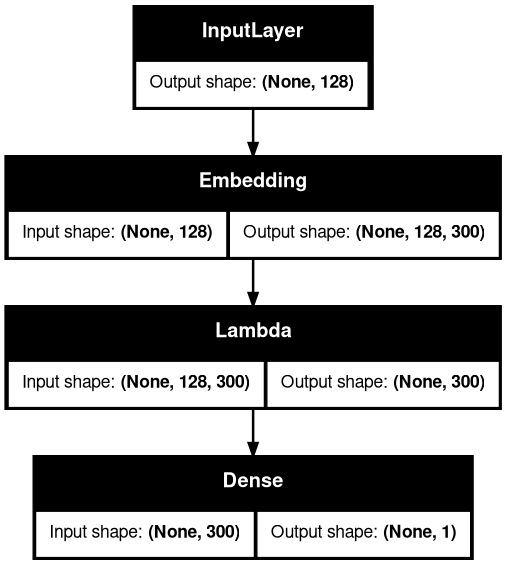

In [28]:
keras.utils.plot_model(an_model, show_shapes=True, dpi=90)

Let's look at the predictions and labels **before** training. Do those make sense?  Do you notice anything about the probabilities?

In [29]:
print('predictions:\n', an_model.predict(train_input[:5]))
print('\n\nGold labels:\n', train_labels[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


I0000 00:00:1757717023.436847 1042524 service.cc:152] XLA service 0x7f419c015ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757717023.436876 1042524 service.cc:160]   StreamExecutor device (0): NVIDIA A30, Compute Capability 8.0
2025-09-12 15:43:43.443289: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1757717023.457151 1042524 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1757717023.570506 1042524 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


predictions:
 [[0.5060513 ]
 [0.5065714 ]
 [0.5019505 ]
 [0.50339764]
 [0.5020255 ]]


Gold labels:
 [0 0 0 1 1]


In [30]:
an_history = an_model.fit(train_input,
                          train_labels,
                          validation_data=(test_input, test_labels),
                          batch_size=32,
                          epochs=20
                          )

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5733 - loss: 0.6878 - val_accuracy: 0.6430 - val_loss: 0.6838
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6525 - loss: 0.6779 - val_accuracy: 0.6250 - val_loss: 0.6761
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6618 - loss: 0.6693 - val_accuracy: 0.6538 - val_loss: 0.6684
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6682 - loss: 0.6616 - val_accuracy: 0.6548 - val_loss: 0.6620
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6736 - loss: 0.6546 - val_accuracy: 0.6606 - val_loss: 0.6559
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6780 - loss: 0.6483 - val_accuracy: 0.6682 - val_loss: 0.6503
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6831 - loss: 0.6424 - val_accuracy: 0.6708 - val_loss: 0.6452
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6889 - loss: 0.6370 - val_accuracy: 0.

Let's revisit the predictions. How is this?

In [31]:
print('predictions:\n', an_model.predict(train_input[:5]))
print('\n\nlabels:\n', train_labels[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
predictions:
 [[0.3278272 ]
 [0.31335178]
 [0.5942831 ]
 [0.6326933 ]
 [0.5276116 ]]


labels:
 [0 0 0 1 1]


That learned somewhat, can we do better?

[Return to Top](#returnToTop)  
<a id = 'modelDAN'></a>
### 3.2. Deep Averaging Network (DAN)

Now let's add some hidden layers after the averaging layer, to give our model more depth. The first and last layers are the same as above.

We'll also put our model creation code into a function, with variables for the things we can change (in this case, the hidden layers). Then we can try different values later.

In [32]:
def build_dan_model(hidden_layer_dims, dropout_rate, embeddings_trainable=False):
    """
    Build a Deep Averaging Network (DAN) model for text classification.

    Parameters
    ----------
    hidden_layer_dims : list of int
        Sizes of the hidden dense layers (e.g., [128, 64]).
    dropout_rate : float
        Dropout rate applied after each hidden dense layer to reduce overfitting.
    embeddings_trainable : bool, optional (default=False)
        Whether pretrained word embeddings should be fine-tuned (True) or frozen (False).

    Returns
    -------
    dan_model : keras.Model
        A compiled Keras model ready for training.
    """

    # ------------------------------------------------------------
    # Step 1: Input layer
    # ------------------------------------------------------------
    # Input is a fixed-length sequence of vocab IDs (integers).
    dan_input_layer = keras.layers.Input(
        shape=(MAX_SEQUENCE_LENGTH,), 
        dtype='int64'
    )

    # ------------------------------------------------------------
    # Step 2: Embedding layer
    # ------------------------------------------------------------
    # Maps integer IDs → pretrained word vectors (embedding_matrix).
    # embeddings_trainable controls whether embeddings are frozen or updated.
    dan_embedding_layer = Embedding(
        input_dim=embedding_matrix.shape[0],    # vocab size
        output_dim=embedding_matrix.shape[1],   # embedding dim
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=embeddings_trainable
    )
    dan_embeddings = dan_embedding_layer(dan_input_layer)
    # Shape: (batch_size, MAX_SEQUENCE_LENGTH, embedding_dim)

    # ------------------------------------------------------------
    # Step 3: Average embeddings
    # ------------------------------------------------------------
    # Compute the mean embedding for each document (bag-of-words style).
    # Reduces 3D tensor → 2D tensor: (batch_size, embedding_dim)
    dan_avg_embeddings = keras.layers.Lambda(
        lambda x: keras.ops.mean(x, axis=1),
        output_shape=(embedding_matrix.shape[1],),
        name='averaging'
    )(dan_embeddings)

    # Initialize last_hidden_output to pass through hidden layers next.
    last_hidden_output = dan_avg_embeddings

    # ------------------------------------------------------------
    # Step 4: Hidden dense + dropout layers
    # ------------------------------------------------------------
    # Add as many dense layers as specified in hidden_layer_dims.
    for i, h_dim in enumerate(hidden_layer_dims):
        # Fully connected hidden layer with ReLU activation
        last_hidden_output = keras.layers.Dense(
            h_dim, activation='relu', name=f'dan_hidden_{i}'
        )(last_hidden_output)

        # Dropout regularization to prevent overfitting
        last_hidden_output = keras.layers.Dropout(dropout_rate)(last_hidden_output)

    # ------------------------------------------------------------
    # Step 5: Output classification layer
    # ------------------------------------------------------------
    # Final dense layer with sigmoid activation for binary classification.
    dan_classification = keras.layers.Dense(
        1, activation='sigmoid', name='dan_classification'
    )(last_hidden_output)

    # ------------------------------------------------------------
    # Step 6: Build and compile model
    # ------------------------------------------------------------
    dan_model = keras.models.Model(
        inputs=dan_input_layer,
        outputs=[dan_classification]
    )

    # Compile with binary crossentropy loss and Adam optimizer
    dan_model.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(
            learning_rate=0.001,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07,
            amsgrad=False,
            name='Adam'
        ),
        metrics=['accuracy']
    )

    return dan_model


/share/crsp/lab/pkaiser/ddlin/mids/datasci-266/2025-fall-main/.venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


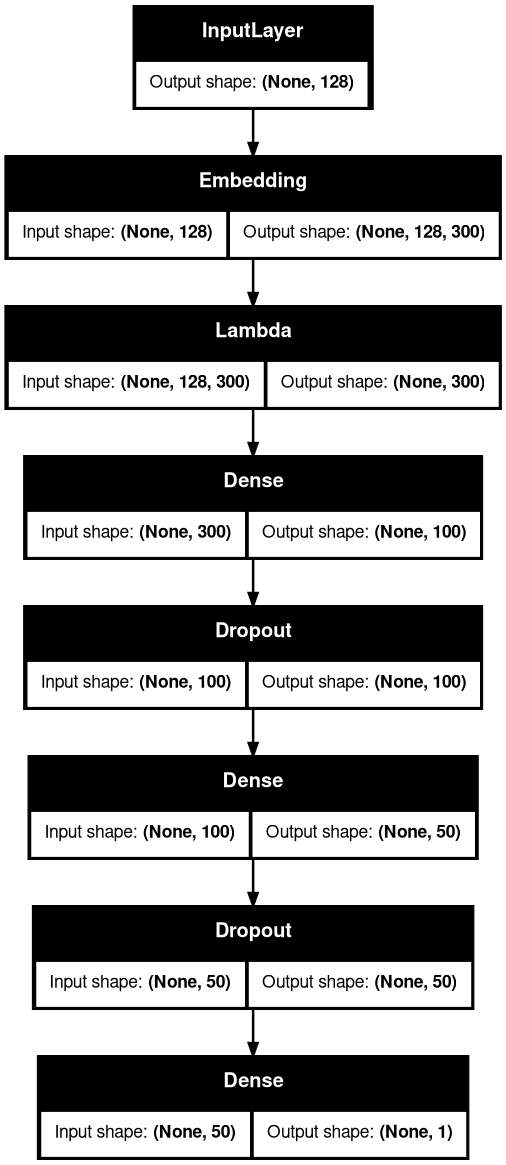

In [33]:
# Now call our function to create a DAN model, and show the model diagram

hidden_layer_sizes = [100, 50] # two hidden layers with 100 and 50 units
dropout_rate = 0.5

dan_model = build_dan_model(hidden_layer_sizes, dropout_rate)
keras.utils.plot_model(dan_model, show_shapes=True, dpi=90)

In [34]:
dan_history = dan_model.fit(train_input,
                            train_labels,
                            validation_data=(test_input, test_labels),
                            batch_size=32,
                            epochs=20
                            )

Epoch 1/20


2025-09-12 16:08:07.657147: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_784', 472 bytes spill stores, 472 bytes spill loads

2025-09-12 16:08:07.815964: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_784', 80 bytes spill stores, 80 bytes spill loads

2025-09-12 16:08:07.963109: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_784_0', 160 bytes spill stores, 160 bytes spill loads

2025-09-12 16:08:08.842993: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_784', 296 bytes spill stores, 296 bytes spill loads

2025-09-12 16:08:09.209510: I extern

611/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5694 - loss: 0.6767

2025-09-12 16:08:16.340804: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42_0', 8 bytes spill stores, 8 bytes spill loads

2025-09-12 16:08:16.491658: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42', 232 bytes spill stores, 232 bytes spill loads

2025-09-12 16:08:16.753508: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42', 104 bytes spill stores, 104 bytes spill loads

2025-09-12 16:08:17.778258: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42', 104 bytes spill stores, 104 bytes spill loads

2025-09-12 16:08:18.784570: I external/loc

625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.6273 - loss: 0.6414 - val_accuracy: 0.7264 - val_loss: 0.5498
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7408 - loss: 0.5297 - val_accuracy: 0.7534 - val_loss: 0.5038
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7549 - loss: 0.5076 - val_accuracy: 0.7572 - val_loss: 0.4952
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7640 - loss: 0.4956 - val_accuracy: 0.7602 - val_loss: 0.4904
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7645 - loss: 0.4891 - val_accuracy: 0.7634 - val_loss: 0.4854
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7695 - loss: 0.4839 - val_accuracy: 0.7690 - val_loss: 0.4851
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7749 - loss: 0.4773 - val_accuracy: 0.7612 - val_loss: 0.4888
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7732 - loss: 0.4775 - val_accuracy: 0.7734 - va

Below is a sample plot for two different models:

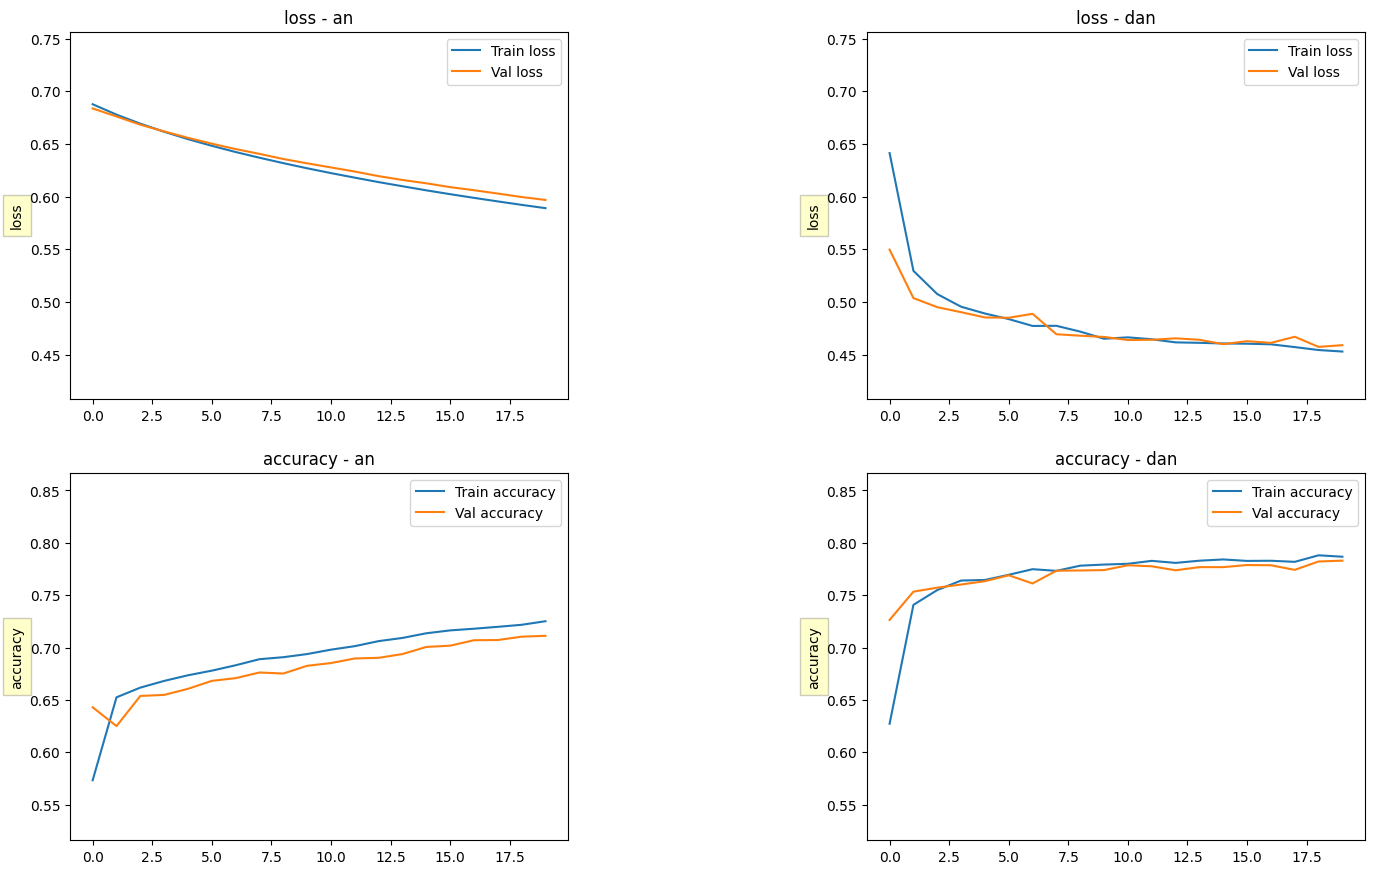

In [36]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          an_history,
          dan_history,
          model_1_name='an',
          model_2_name='dan')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

Of course, the avergaing network is not done training.

[Return to Top](#returnToTop)  
<a id = 'modelCNN'></a>
### 3.3 CNN Model

Next let's build a CNN model. We'll also wrap the model building code in a function that takes some hyperparameters, so that we can adjust things like number of filters and filter sizes later.

In [37]:
def build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    """
    Build a CNN-based text classification model.

    Parameters
    ----------
    num_filters : list of int
        Number of convolution filters for each kernel size.
        Example: [100, 100, 100].
    kernel_sizes : list of int
        Filter (window) sizes for the convolutions.
        Example: [3, 4, 5] → tri-grams, 4-grams, 5-grams.
    dense_layer_dims : list of int
        Sizes of fully connected dense layers after convolution.
    dropout_rate : float
        Dropout rate applied after concatenating convolution outputs.
    embeddings_trainable : bool, optional (default=False)
        Whether pretrained embeddings should be fine-tuned.

    Returns
    -------
    cnn_model : keras.Model
        A compiled Keras model ready for training.
    """

    # ------------------------------------------------------------
    # Step 1: Input & Embedding
    # ------------------------------------------------------------
    # Input: sequences of integer vocab IDs
    cnn_input_layer = keras.layers.Input(
        shape=(MAX_SEQUENCE_LENGTH,), dtype='int64'
    )

    # Embedding layer: maps vocab IDs → pretrained word vectors
    cnn_embedding_layer = Embedding(
        input_dim=embedding_matrix.shape[0],    # vocab size
        output_dim=embedding_matrix.shape[1],   # embedding dimension
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=embeddings_trainable
    )
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)
    # Shape: (batch_size, MAX_SEQUENCE_LENGTH, embedding_dim)

    # ------------------------------------------------------------
    # Step 2: Convolution + Global Max Pooling
    # ------------------------------------------------------------
    # Apply multiple Conv1D filters with different kernel sizes
    # to capture n-gram features (e.g., tri-grams, 4-grams, etc.).
    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        # Convolution layer
        conv_layer = keras.layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            activation='relu'
        )(cnn_embeddings)
        # Shape: (batch_size, MAX_SEQUENCE_LENGTH - kernel_size + 1, filters)

        # Global max pooling → pick strongest signal across sequence
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        # Shape: (batch_size, filters)

        # Collect this conv output
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    # Concatenate outputs from all conv layers
    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    # Shape: (batch_size, sum(num_filters))

    # ------------------------------------------------------------
    # Step 3: Dropout regularization
    # ------------------------------------------------------------
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(conv_output)

    # ------------------------------------------------------------
    # Step 4: Dense hidden layers
    # ------------------------------------------------------------
    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(
            dense_layer_dim, activation='relu'
        )(last_hidden_output)

    # ------------------------------------------------------------
    # Step 5: Output layer
    # ------------------------------------------------------------
    # Single sigmoid neuron for binary classification
    cnn_prediction = keras.layers.Dense(
        1, activation='sigmoid'
    )(last_hidden_output)

    # ------------------------------------------------------------
    # Step 6: Build & compile model
    # ------------------------------------------------------------
    cnn_model = keras.Model(
        inputs=cnn_input_layer,
        outputs=cnn_prediction
    )

    cnn_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',   # common for binary classification
        metrics=['accuracy']
    )

    return cnn_model


In [ ]:
# ------------------------------------------------------------
# Step 1: Define CNN hyperparameters
# ------------------------------------------------------------

# Number of filters (output channels) for each convolution layer.
# Matches one-to-one with kernel_sizes below.
# Example: for kernel_size=3 → 100 filters, etc.
num_filters = [100, 100, 50, 25]

# Convolution kernel sizes (window widths over the sequence).
#   3 → tri-grams
#   4 → 4-grams
#   5 → 5-grams
#   10 → longer patterns spanning 10 tokens
kernel_sizes = [3, 4, 5, 10]

# Sizes of fully connected dense layers after convolution outputs
#   First dense layer → 100 units
#   Second dense layer → 50 units
dense_layer_dims = [100, 50]

# Dropout rate (fraction of units randomly dropped during training)
# Applied after concatenating convolution outputs → helps prevent overfitting
dropout_rate = 0.5

# ------------------------------------------------------------
# Step 2: Build the CNN model
# ------------------------------------------------------------
# Calls the build_cnn_model function we defined earlier.
# - Uses the hyperparameters specified above.
# - By default, embeddings_trainable=False, so pretrained embeddings are frozen.
cnn_model = build_cnn_model(
    num_filters=num_filters,
    kernel_sizes=kernel_sizes,
    dense_layer_dims=dense_layer_dims,
    dropout_rate=dropout_rate
)


/share/crsp/lab/pkaiser/ddlin/mids/datasci-266/2025-fall-main/.venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [39]:
cnn_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 128, 300)  │ 13,194,600 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 126, 100)  │     90,100 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 125, 100)  │    120,100 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 124, 50)   │     75,050 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 119, 25)   │     75,025 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 100)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 100)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 50)        │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 25)        │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 275)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 275)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100)       │     27,600 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 50)        │      5,050 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         51 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,587,576 (51.83 MB)

 Trainable params: 392,976 (1.50 MB)

 Non-trainable params: 13,194,600 (50.33 MB)

The keras plot utility shows this probably a bit nicer:

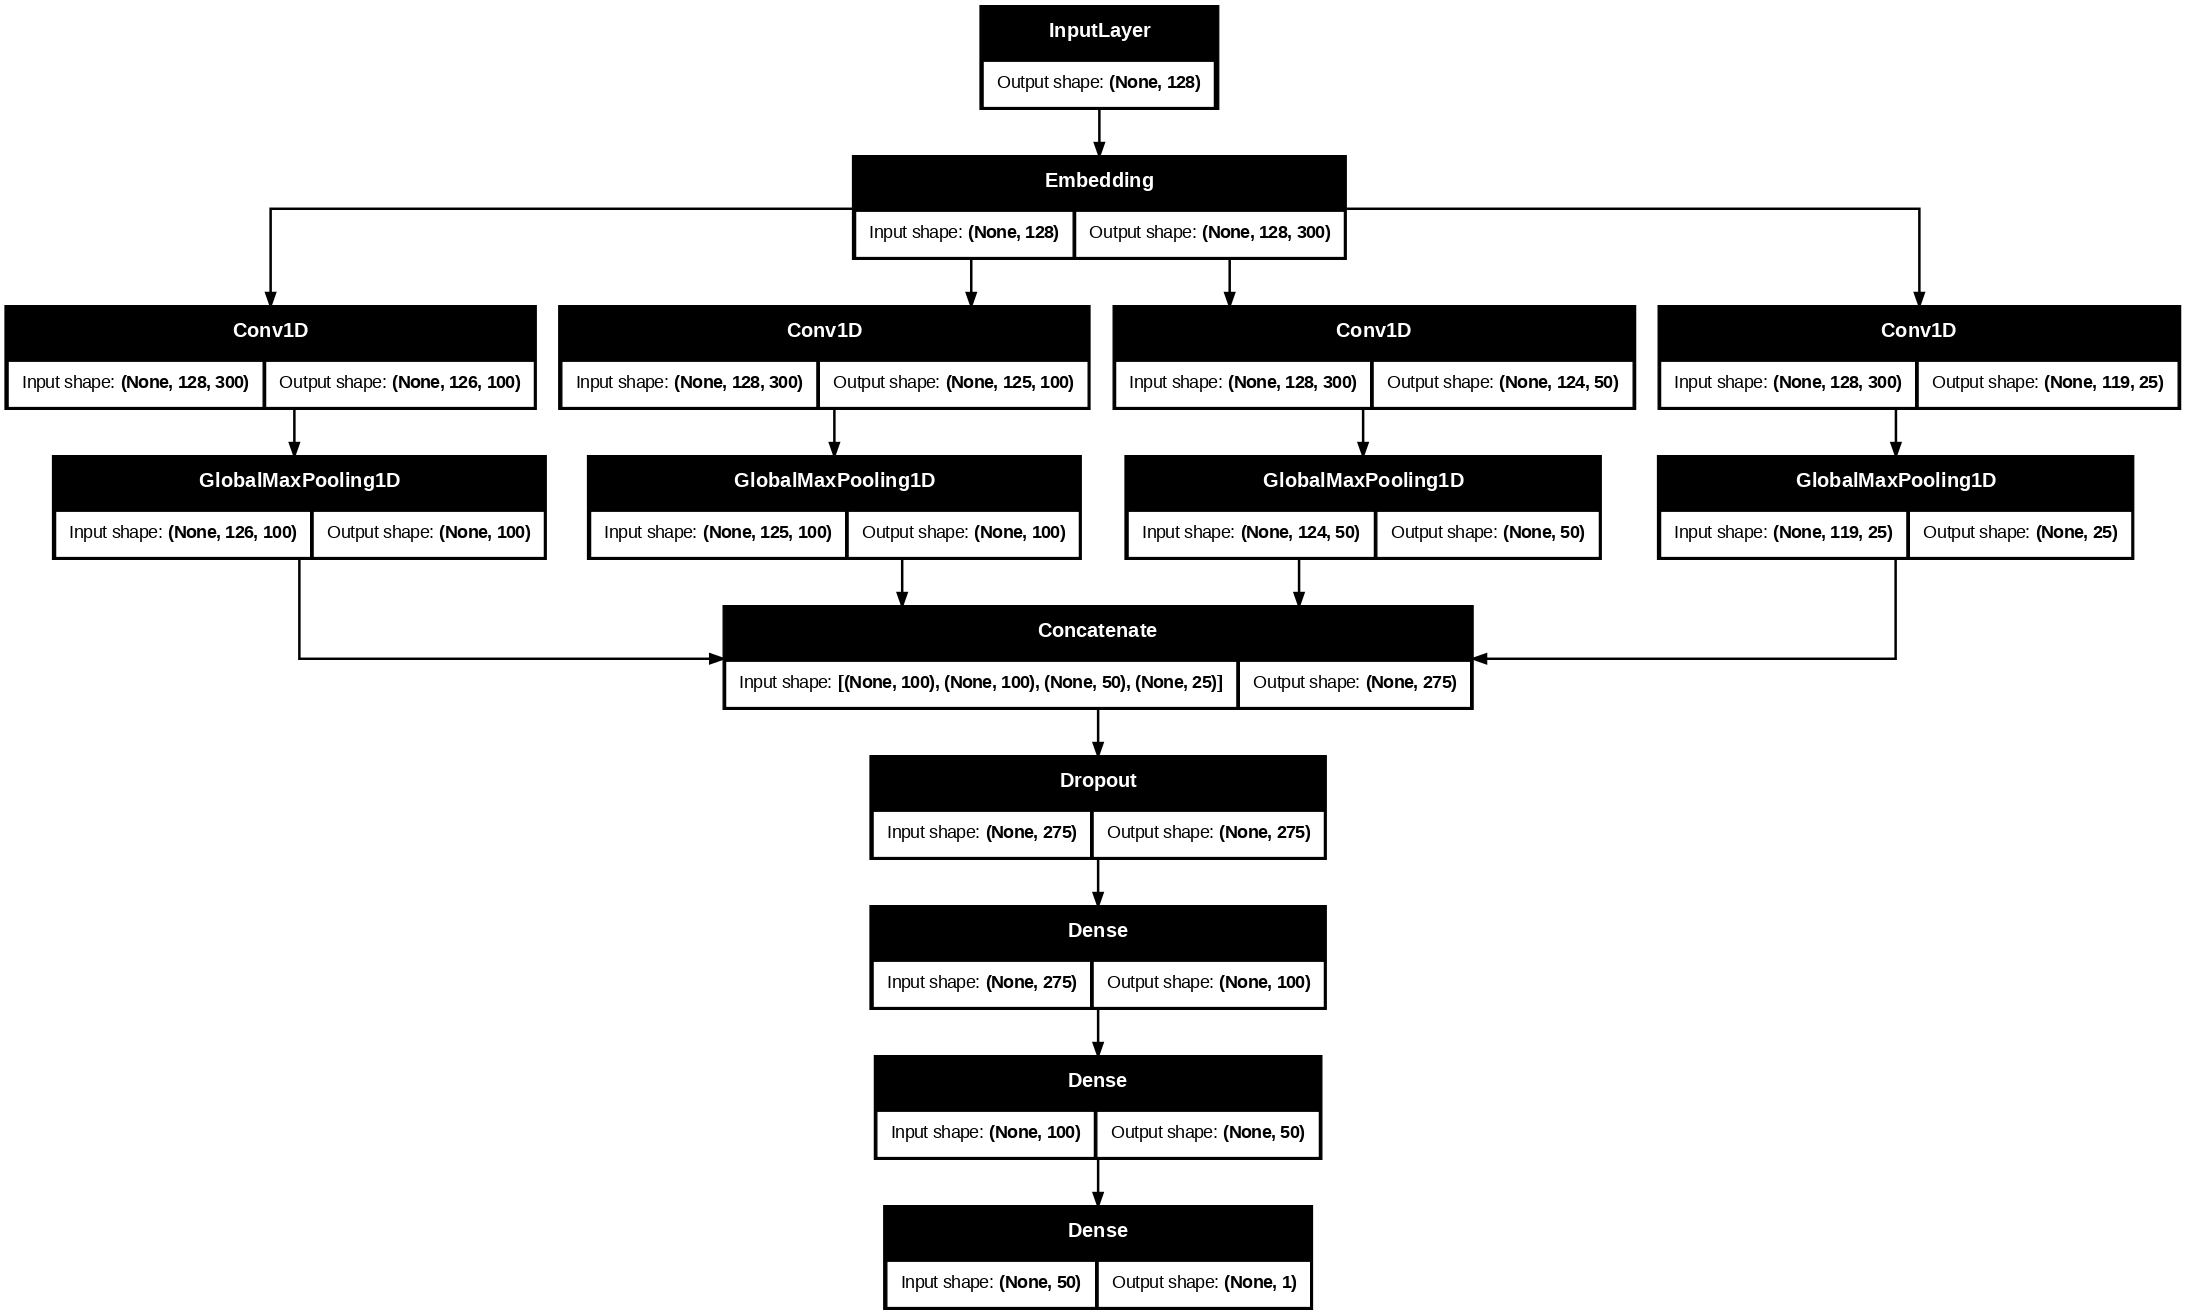

In [ ]:
keras.utils.plot_model(cnn_model, show_shapes=True, dpi=90)

In [40]:
cnn_history = cnn_model.fit(train_input,
                            train_labels,
                            validation_data=(test_input, test_labels),
                            batch_size=32,
                            epochs=5
                            )

Epoch 1/5


625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7102 - loss: 0.5411 - val_accuracy: 0.7896 - val_loss: 0.4472
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8030 - loss: 0.4241 - val_accuracy: 0.8084 - val_loss: 0.4058
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8344 - loss: 0.3747 - val_accuracy: 0.8112 - val_loss: 0.4112
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8615 - loss: 0.3273 - val_accuracy: 0.8208 - val_loss: 0.3907
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8831 - loss: 0.2796 - val_accuracy: 0.8124 - val_loss: 0.4194


Below is a comparison of a CNN model with a DAN model:

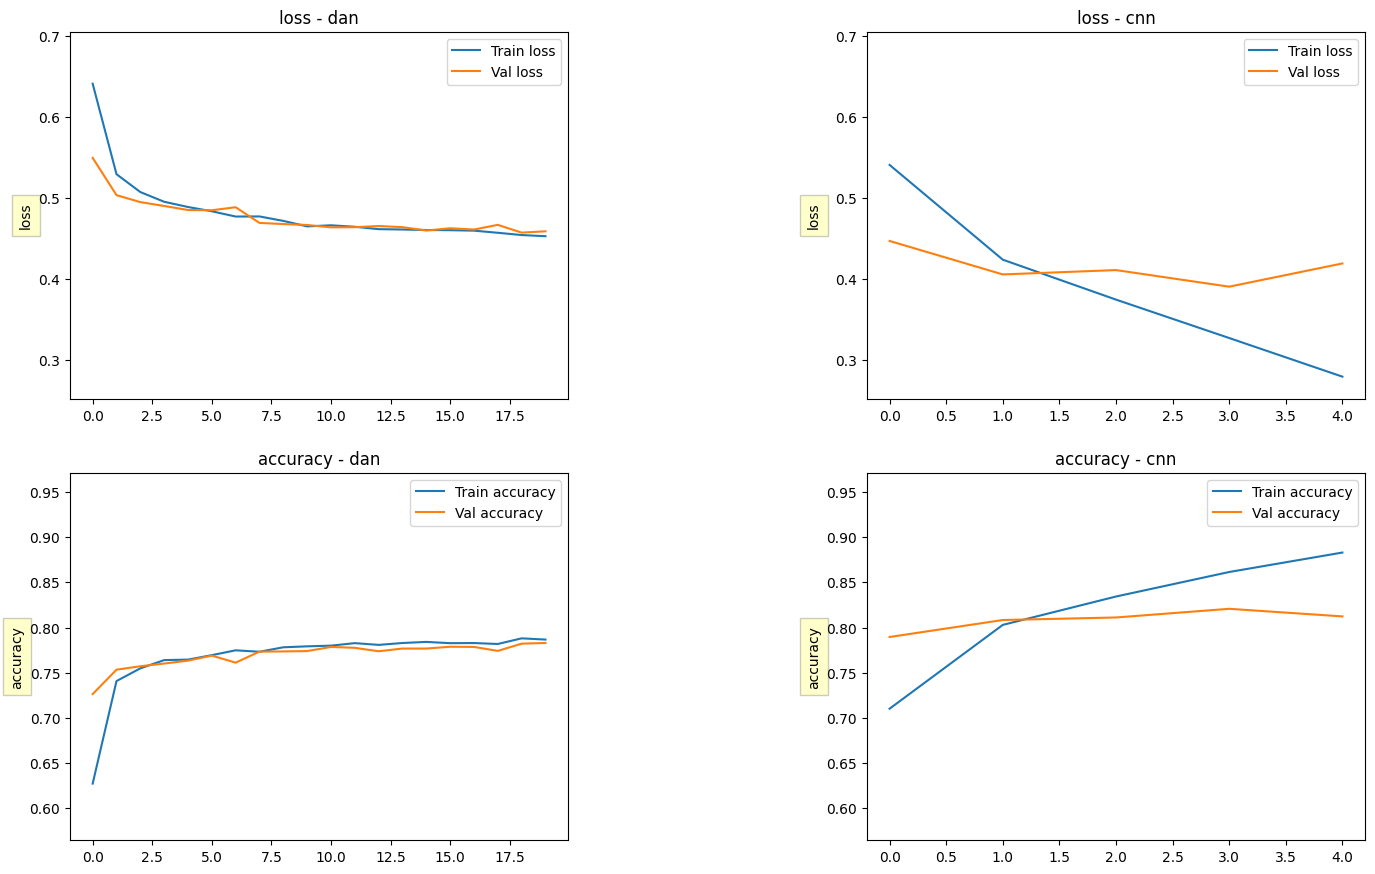

In [41]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          dan_history,
          cnn_history,
          model_1_name='dan',
          model_2_name='cnn')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

[Return to Top](#returnToTop)  
<a id = 'inClassExercises'></a>
### 3.4. In-Class Exercises

A. Are any of the models above overfitting? Can you make them overfit less, or more? What parameters might you change to make these models more or less likely to overfit? How good (or bad) can you make it get?

> Hint: think about all of the options you can vary, including:
* add/remove more hidden layers
* vary dropout rates and dimensions
* enable/disable retraining of embedding matrix
* (for CNN) change number of filters
* (for CNN) change kernel sizes of filters
>
> For the option(s) you choose, do you think it will make the model more or less likely to overfit? Try it, does it work the way you expect?


B. Can you make any of these models train faster (or slower)? What parameters might you change to make that happen? Again, does it work how you expect when you try it?

You can use the cells below to explore either/both the DAN and CNN, using the functions defined above.

In [42]:
# DAN model hyperparameters: Change these?
hidden_layer_sizes = [100, 50]
dropout_rate = 0.5
embeddings_trainable = False

dan_model2 = build_dan_model(hidden_layer_sizes, dropout_rate,
                             embeddings_trainable)

dan_history2 = dan_model2.fit(train_input,
                              train_labels,
                              validation_data=(test_input, test_labels),
                              batch_size=32,
                              epochs=20
                              )

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6379 - loss: 0.6343 - val_accuracy: 0.7226 - val_loss: 0.5562
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7432 - loss: 0.5277 - val_accuracy: 0.7518 - val_loss: 0.5033
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7569 - loss: 0.5063 - val_accuracy: 0.7638 - val_loss: 0.4907
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7641 - loss: 0.4962 - val_accuracy: 0.7586 - val_loss: 0.4983
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7696 - loss: 0.4869 - val_accuracy: 0.7650 - val_loss: 0.4816
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7707 - loss: 0.4812 - val_accuracy: 0.7720 - val_loss: 0.4748
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7743 - loss: 0.4767 - val_accuracy: 0.7660 - val_loss: 0.4796
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7771 - loss: 0.4716 - val_accuracy: 0.

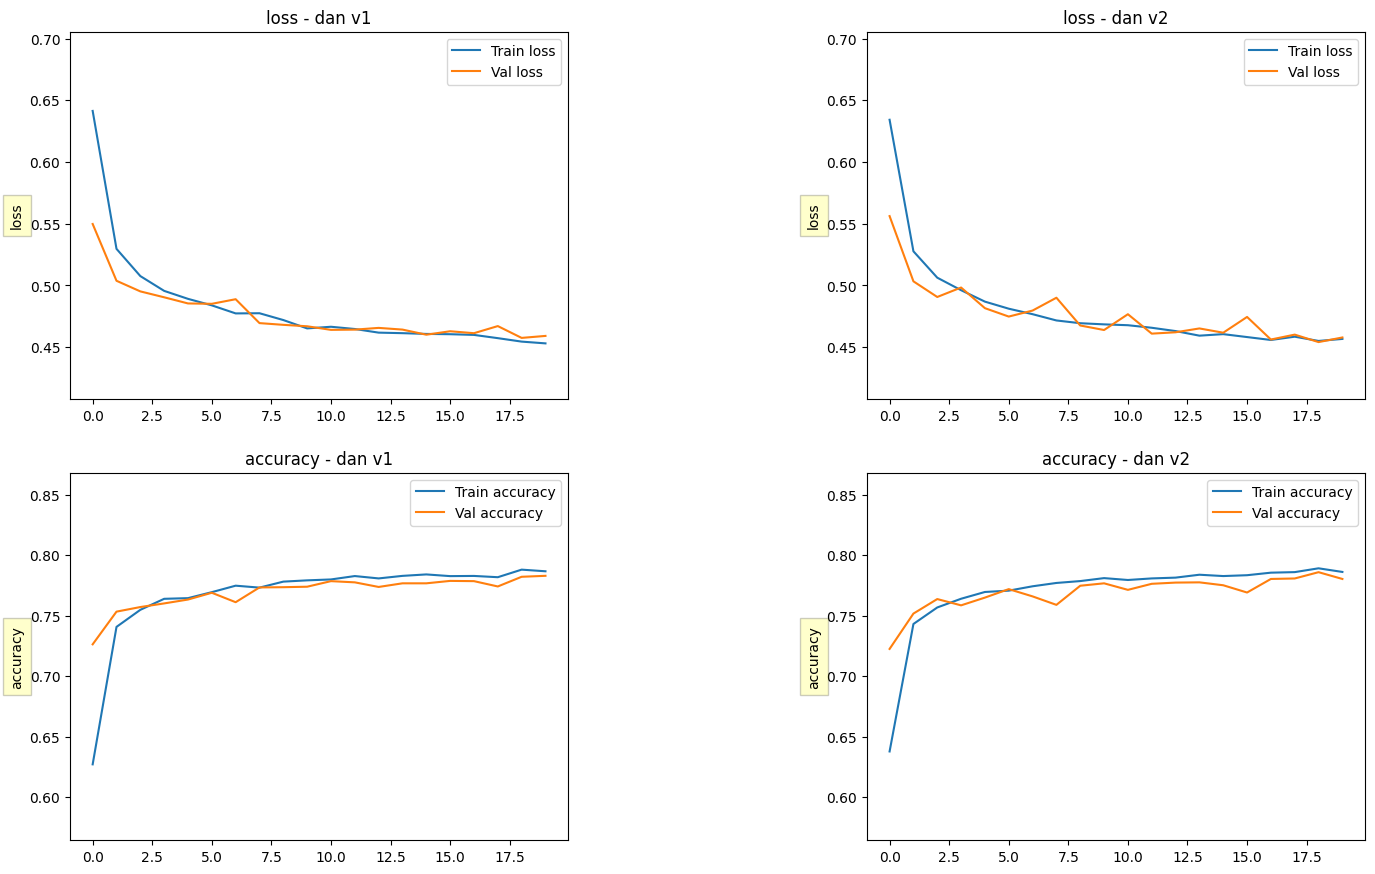

In [46]:
# Do the plots change how you'd expect?
# Did the runtime change (in the cells above)?

fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          dan_history,
          dan_history2,
          model_1_name='dan v1',
          model_2_name='dan v2')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

In [47]:
# CNN model hyperparameters: Change these?
num_filters = [100, 100, 50, 25]
kernel_sizes = [3, 4, 5, 10]
dense_layer_dims = [100, 50]
dropout_rate = 0.5
embeddings_trainable = False

cnn_model2 = build_cnn_model(num_filters, kernel_sizes, dense_layer_dims,
                            dropout_rate, embeddings_trainable)

cnn_history2 = cnn_model2.fit(train_input,
                              train_labels,
                              validation_data=(test_input, test_labels),
                              batch_size=32,
                              epochs=5
                              )

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7081 - loss: 0.5426 - val_accuracy: 0.8032 - val_loss: 0.4292
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8072 - loss: 0.4200 - val_accuracy: 0.8158 - val_loss: 0.4078
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8341 - loss: 0.3694 - val_accuracy: 0.8180 - val_loss: 0.4080
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8597 - loss: 0.3245 - val_accuracy: 0.8204 - val_loss: 0.4048
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8816 - loss: 0.2774 - val_accuracy: 0.8206 - val_loss: 0.4085


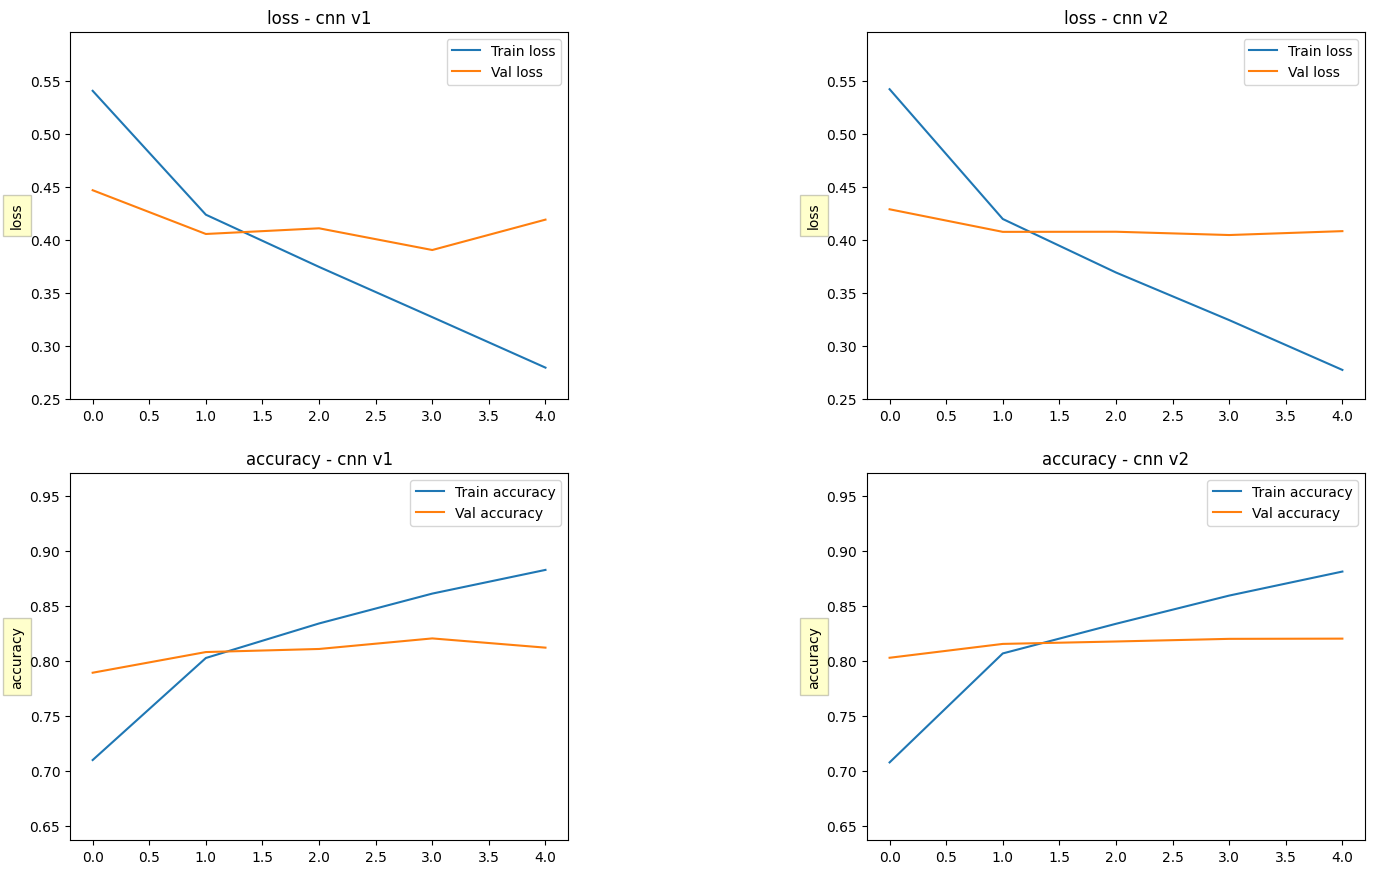

In [48]:
# Do the plots change how you'd expect?
# Did the runtime change (in the cells above)?

fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          cnn_history,
          cnn_history2,
          model_1_name='cnn v1',
          model_2_name='cnn v2')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

This finalizes the discussions of DANs and CNNs.

Over the next 2 weeks we will first add RNNs and then also classification with BERT.